In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktr
import torch as to
import torchvision as tovi
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class Data(Dataset) :
    
    def __init__(self):
        
        super(Data,self).__init__()
        
        self.data = pd.read_csv("../../data/trainMNIST.csv").values
        self.label = pd.read_csv("../../data/trainMNISTlabels.csv").values
    
    
    def __getitem__(self, inx) :
        
        sample = self.data[inx]
        label = self.label[inx]
        
        img = np.reshape(sample,(1,28,28))
        
        img = to.tensor(img, dtype=to.float32, device="cuda")
        label = to.tensor(label, dtype=to.float32, device="cuda")
        
        return img, label
        
    
    def __len__(self):
        
        return len(self.data)

architecture :

$$1\times28\times28 \xrightarrow{\text{conv:} k_5,s_1}  16 \times 24 \times24 \xrightarrow{\text{maxp:} k_2,s_2} 16\times12\times12 \xrightarrow{\text{conv:}k_3,s_1} 32\times10\times10 \xrightarrow{\text{maxp:}k_2,s_2} 32\times5\times5$$

In [3]:
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        
        
    def encoder(self,inp):
        
        out = self.conv1(inp)
        out = F.relu(out)
        out, self.inx1 = self.pool(out)
        
        
        out = self.conv2(out)
        out = F.relu(out)
        out, self.inx2 = self.pool(out)           
        
        
        return out
        
               
    def decoder(self,inp):
        
        self.copy1 = to.tensor(self.conv1.weight, requires_grad=False)
        self.copy2 = to.tensor(self.conv2.weight, requires_grad=False)
        
        out = F.max_unpool2d(inp, self.inx2, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy2 )
        out = F.relu(out)
                
        out = F.max_unpool2d(out, self.inx1, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy1 )
        
        out = F.tanh(out)
        
        return out
        
        
    
    def forward(self,inp):
        
        out = self.encoder(inp)
        out = self.decoder(out)
        
        return out

In [4]:
model = Model().cuda()

In [5]:
train_data = Data()
data_loader = DataLoader(train_data,batch_size=32, shuffle=True)

label : tensor([4.], device='cuda:0')


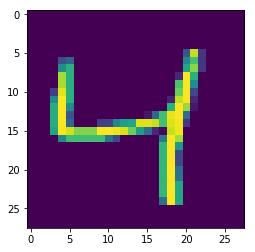

In [6]:
sample, lbl = train_data[1]

print("label :", lbl)

img = sample.detach().cpu().numpy()
plt.imshow(img[0])

In [7]:
epoch = 100
lr = 0.001
Criterion = nn.MSELoss()
Optimizer = to.optim.SGD(model.parameters(), lr=lr)

In [8]:
counter = []
loss_history = [] 
iteration_number= 0

In [9]:
for i in range(epoch):
    
    for data in data_loader :
        
        img, lbl = data
        
        out = model(img)
        loss = Criterion(out,img)
        
        
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        
    print("Epoch number {}\n  Current loss {}\n".format(i,loss.item()))
    counter.append(i)
    loss_history.append(loss.item())
        

/usr/local/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch number 0
  Current loss 6673.47265625

Epoch number 1
  Current loss 7415.4140625

Epoch number 2
  Current loss 5929.67626953125

Epoch number 3
  Current loss 7189.005859375

Epoch number 4
  Current loss 6961.43505859375

Epoch number 5
  Current loss 7248.0185546875

Epoch number 6
  Current loss 7901.38232421875

Epoch number 7
  Current loss 7483.59912109375

Epoch number 8
  Current loss 7083.56396484375

Epoch number 9
  Current loss 6795.74658203125

Epoch number 10
  Current loss 7766.8134765625

Epoch number 11
  Current loss 7242.3701171875

Epoch number 12
  Current loss 8070.29248046875

Epoch number 13
  Current loss 8342.0478515625

Epoch number 14
  Current loss 7424.02392578125

Epoch number 15
  Current loss 8116.23828125

Epoch number 16
  Current loss 7612.55712890625

Epoch number 17
  Current loss 7069.20458984375

Epoch number 18
  Current loss 6257.6328125

Epoch number 19
  Current loss 7168.18115234375

Epoch number 20
  Current loss 7575.76953125

Epoc

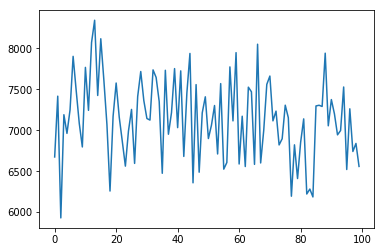

In [10]:
plt.plot(counter,loss_history)

In [11]:
to.save(model.state_dict(),"./autoencoder")

In [12]:
model.eval()

Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

label : tensor([6.], device='cuda:0')


/usr/local/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


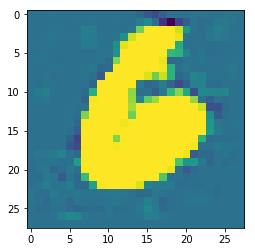

In [18]:
sample, lbl = train_data[12]

print("label :", lbl)

with to.no_grad() :
    out = model(sample.view(1,1,28,28))

img = out.detach().cpu().numpy()
plt.imshow(img[0][0])